In [50]:
#pip install seaborn
#pip install astropy
#pip install intersect

In [51]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from intersect import intersection
from PIL import Image

In [52]:
"""
Methodology:
loop through timestamps of skyprobe measurements, for each one find a timestamp in the telescope data within +/- 1 
minute as well as an ASIVA image with a timestamp within +/- 1 minute. 
output a csv file with 5 columns as follows:
1 - skyprobe timestamp
2 - Skyprobe attenuation
3 - telescope Az
4 - Telescope Alt
5 - ASIVA Image Filename
"""

'\nMethodology:\nloop through timestamps of skyprobe measurements, for each one find a timestamp in the telescope data within +/- 1 \nminute as well as an ASIVA image with a timestamp within +/- 1 minute. \noutput a csv file with 5 columns as follows:\n1 - skyprobe timestamp\n2 - Skyprobe attenuation\n3 - telescope Az\n4 - Telescope Alt\n5 - ASIVA Image Filename\n'

In [53]:
"""File Parsing:
Skyprobe Data:
Column 1: Time in UNIX EPOCH
Column 4: Zeropoint (Attenuation)

Telescope Data:
Column 1: Time in UNIX Epoch
Column 2: Alt
Column 3: Az

ASIVA Images:
naming example: asiva202301251900.png
naming format: asivaYYYYMMDDHHMM
HH in military time
"""

'File Parsing:\nSkyprobe Data:\nColumn 1: Time in UNIX EPOCH\nColumn 4: Zeropoint (Attenuation)\n\nTelescope Data:\nColumn 1: Time in UNIX Epoch\nColumn 2: Alt\nColumn 3: Az\n\nASIVA Images:\nnaming example: asiva202301251900.png\nnaming format: asivaYYYYMMDDHHMM\nHH in military time\n'

In [54]:


DF_skyprobe = pd.read_csv("skyprobe_data.csv", low_memory=False)
DF_skyprobe.columns = ['Time', 'skip1', 'skip2', 'attenuation', 'skip3', 'skip4']
DF_skyprobe = DF_skyprobe.drop(columns = ['skip1', 'skip2', 'skip3', 'skip4'])
DF_telescope = pd.read_csv("tcs_data.csv", low_memory=False)
DF_telescope.columns = ['Time', 'Alt', 'Az', 'skip']
DF_telescope = DF_telescope.drop(columns = ['skip'])
DF = pd.merge_asof(DF_skyprobe, DF_telescope, on = "Time", direction="nearest", tolerance=60)
DF = DF.dropna()
print(DF.head)



<bound method NDFrame.head of                Time  attenuation      Alt        Az
0        1274851510        0.107  89.8103  279.5074
1        1274851809        0.155  67.7496   80.3481
2        1274851870        0.144  67.7496   80.3481
3        1274851929        0.559  67.7496   80.3481
4        1274851989        0.121  67.7496   80.3481
...             ...          ...      ...       ...
2125491  1694792290       -0.108  64.9583   48.1660
2125492  1694792350        0.151  64.9213   48.1046
2125493  1694792407       -0.183  64.8382   48.1806
2125494  1694792470        0.004  65.0426   47.9788
2125495  1694793600        0.004  64.9767   48.1581

[1647649 rows x 4 columns]>


In [55]:
#we now have a combined dataset of skyprobe data with corresponding Alt and Az values.
#Now we need to find ASIVA images with close timestamps and add the filenames to the dataframe

folder = "../images"
filenames = []
timestamps = []
for file in glob.glob(folder + '/*.png'):
    filedate = file.split('/')[2].split('asiva')[1].split('.')[-2]
    time = datetime.strptime(filedate, '%Y%m%d%H%M') + timedelta(hours=10)
    print(time)
    timestamp = datetime.timestamp(time)
    filenames.append(file)
    print(timestamp)
    timestamps.append(int(timestamp))
    #convert filedate/time to UNIX. Add 10 hours for converting HST to UTC
DF_ASIVA = pd.DataFrame(timestamps)
DF_ASIVA.columns = ["Time"]
DF_ASIVA["filenames"] = filenames
DF_ASIVA = DF_ASIVA.sort_values(by="Time")
print(DF_ASIVA.head)


2023-06-28 12:36:00
1687970160.0
2023-06-21 11:43:00
1687362180.0
2023-04-18 07:07:00
1681816020.0
2023-06-22 06:32:00
1687429920.0
2023-06-22 06:26:00
1687429560.0
2023-06-21 11:57:00
1687363020.0
2023-04-18 07:13:00
1681816380.0
2023-06-28 12:22:00
1687969320.0
2023-02-04 12:13:00
1675530780.0
2023-02-04 12:07:00
1675530420.0
2023-06-22 10:43:00
1687444980.0
2023-01-26 09:14:00
1674742440.0
2023-06-23 07:32:00
1687519920.0
2023-06-23 07:26:00
1687519560.0
2023-06-22 10:57:00
1687445820.0
2023-01-26 09:00:00
1674741600.0
2023-02-04 07:08:00
1675512480.0
2023-01-26 09:28:00
1674743280.0
2023-02-04 07:20:00
1675513200.0
2023-02-04 07:34:00
1675514040.0
2023-06-22 08:30:00
1687437000.0
2023-04-18 09:05:00
1681823100.0
2023-06-21 13:41:00
1687369260.0
2023-06-28 10:34:00
1687962840.0
2023-06-28 10:20:00
1687962000.0
2023-02-04 10:39:00
1675525140.0
2023-04-18 09:11:00
1681823460.0
2023-06-21 13:55:00
1687370100.0
2023-06-22 08:24:00
1687436640.0
2023-06-28 10:08:00
1687961280.0
2023-02-04

In [56]:
#perform another merge_asof to add asiva filenames to the main dataframe
DF = pd.merge_asof(DF, DF_ASIVA, on = "Time", direction="nearest", tolerance=60)
DF = DF.dropna()
DF = DF.reset_index()
print(DF.head)

<bound method NDFrame.head of        index        Time  attenuation      Alt        Az  \
0    1581249  1675601947        0.092  32.4534  321.3330   
1    1581250  1675602000        0.092  32.4534  321.3330   
2    1581251  1675602006        0.095  32.4534  321.3330   
3    1581252  1675602007        0.095  32.4534  321.3330   
4    1581253  1675602187        0.103  31.4518  321.3330   
..       ...         ...          ...      ...       ...   
882  1616383  1687964890       -0.021  56.4768  142.2442   
883  1616384  1687964950       -0.001  57.4772  142.2442   
884  1616385  1687965010       -0.027  57.4772  143.2486   
885  1616386  1687965067       -0.084  57.4772  143.2486   
886  1616387  1687965130       -0.018  57.4772  143.2486   

                           filenames  
0    ../images/asiva202302042200.png  
1    ../images/asiva202302042200.png  
2    ../images/asiva202302042200.png  
3    ../images/asiva202302042200.png  
4    ../images/asiva202302042203.png  
..             

In [57]:
## Code from https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/
## Posted by: christian on 9 Aug 2021

def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

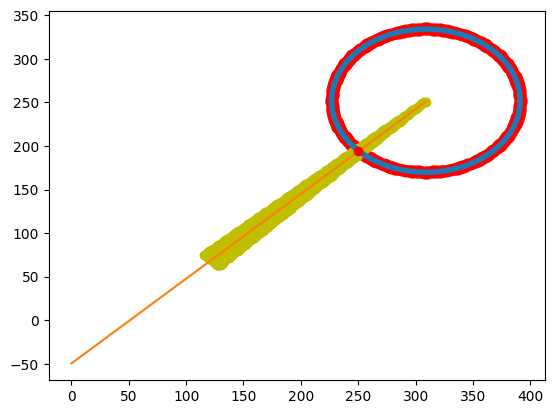

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars


<bound method NDFrame.head of        index        Time  attenuation      Alt        Az  \
0    1581249  1675601947        0.092  32.4534  321.3330   
1    1581250  1675602000        0.092  32.4534  321.3330   
2    1581251  1675602006        0.095  32.4534  321.3330   
3    1581252  1675602007        0.095  32.4534  321.3330   
4    1581253  1675602187        0.103  31.4518  321.3330   
..       ...         ...          ...      ...       ...   
882  1616383  1687964890       -0.021  56.4768  142.2442   
883  1616384  1687964950       -0.001  57.4772  142.2442   
884  1616385  1687965010       -0.027  57.4772  143.2486   
885  1616386  1687965067       -0.084  57.4772  143.2486   
886  1616387  1687965130       -0.018  57.4772  143.2486   

                           filenames Kernel_Location  
0    ../images/asiva202302042200.png      (220, 435)  
1    ../images/asiva202302042200.png      (220, 435)  
2    ../images/asiva202302042200.png      (220, 435)  
3    ../images/asiva202302042

<Figure size 640x480 with 0 Axes>

In [58]:
"""
Now need to find the location within each ASIVA image and save a 12x12 kernel surrounding that location
along with a corresponding attenuation value
Azimuth.fits gives f(x,y) = Az   -- from an (x,y) pair in an ASIVA image gives the corresponding Az
Altitude.fits gives g(x,y) = Alt   -- from an (x,y) pair in an ASIVA image gives the corresponding Alt

I want to construct:
f-1(Az) = (x,y) -- from an Az value input give a set of (x,y) on an ASIVA image that would yield that
g-1(Alt) = (x,y) -- from an Alt value input give a set of (x,y) on an ASIVA image that would yield that

I then want to find the intersection between f-1 and g-1  -- that's where I'll sample the kernel.
"""
#These indices have azimuth values that want to form vertical lines, doen't work for the linear regression model
#DF = DF.reset_index()
problems = [73, 74, 75, 76, 819]
DF = DF.drop(index=problems)
hdul_az = fits.open("azimuth.fits")
hdul_alt = fits.open("altitude.fits")
az_image = hdul_az[0].data
alt_image = hdul_alt[0].data
vals = DF[['Az', 'Alt']]
i = 0
kernel_locs = []

for index, row in vals.iterrows():
    #print(i)
    #if(i not in problems):
    Az = np.float32(row[0])
    Alt = np.float32(row[1])
    az_locs = list(zip(*np.where(abs(az_image - Az) <= 2)))
    alt_locs = list(zip(*np.where(abs(alt_image - Alt) <= 0.5)))
    #Plot Alt data and get regression model for ellipse
    y, x = zip(*alt_locs)
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x, y, color="r")
    coeffs_ellipse = fit_ellipse(x, y)
    x0, y0, ap, bp, e, phi = cart_to_pol(coeffs_ellipse)
    x_e, y_e = get_ellipse_pts((x0, y0, ap, bp, e, phi), npts=1000)
    plt.plot(x_e, y_e, linewidth=4)

    #Plot Az data and get regression model for line
    y, x = zip(*az_locs)
    x = np.array(x)
    y = np.array(y)
    midx = np.mean(x)
    plt.scatter(x, y, color="y")
    x_r = x.reshape((-1, 1))
    model = LinearRegression().fit(x_r, y)
    coeffs_line = [model.coef_, model.intercept_]
    x_pred = np.linspace(0, x0, len(y_e)).reshape((-1, 1))
    y_pred = model.predict(x_pred)
    plt.plot(x_pred.reshape((-1, 1)), y_pred)
    #find the intersection point between the linear and elliptical models.
    x_loc, y_loc = intersection(x_pred, y_pred, x_e, y_e)
    #idx = np.argwhere(np.diff(np.sign(y_e - y_pred))).flatten()
    #x_loc = x_pred[idx]
    #y_loc = y_pred[idx]
    x_loc = int(x_loc[0])
    y_loc = int(y_loc[0])
    kernel_locs.append((x_loc, y_loc))
    if(i == 67):
        plt.plot(x_loc, y_loc, 'ro')
        plt.show()
    i += 1
    plt.clf()
    
DF["Kernel_Location"] = kernel_locs
print(DF.head)
hdul_az.close()
hdul_alt.close()
    
    
    

In [61]:
"""
The format of DF is now 6 columns as follows:
1 - skyprobe timestamp
2 - Skyprobe attenuation
3 - telescope Az
4 - Telescope Alt
5 - ASIVA Image Filename
6 - (x, y) position of the skyprobe measurement in the corresponding ASIVA image

I now need to parse through each filename in the dataframe and extract a kernel surrounding the corresponding (x,y) 
location

"""
size = 6
images = DF[["filenames", "Kernel_Location"]]
image_kernel_filenames = []
for index, row in images.iterrows():
    filename = row[0]
    oldimagename = filename.split('../images/')[1].split('.png')[0]
    loc = row[1]
    im = Image.open(filename)
    x = loc[0]
    y = loc[1]
    imk = im.crop((x-size, y-size, x+size, y+size))
    newfilename =  oldimagename + "_12x12" '.png'
    image_kernel_filenames.append(newfilename)
    imk.save('../kernels/' + newfilename)
#write CSV file containing kernel filenames and corresponding attenuations
attenuations = pd.DataFrame(DF["attenuation"])
attenuations["filename"] = image_kernel_filenames
print(attenuations.head)
attenuations.to_csv("../kernels/attenuations.csv")

<bound method NDFrame.head of      attenuation                     filename
0          0.092  asiva202302042200_12x12.png
1          0.092  asiva202302042200_12x12.png
2          0.095  asiva202302042200_12x12.png
3          0.095  asiva202302042200_12x12.png
4          0.103  asiva202302042203_12x12.png
..           ...                          ...
882       -0.021  asiva202306280108_12x12.png
883       -0.001  asiva202306280109_12x12.png
884       -0.027  asiva202306280110_12x12.png
885       -0.084  asiva202306280111_12x12.png
886       -0.018  asiva202306280112_12x12.png

[882 rows x 2 columns]>


In [ ]:
# demonstrate example kernels and attenuation values.